In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [2]:
import numpy as np
import pandas as pd
import umap

from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


np.random.seed(seed=42) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [3]:
X,y = make_classification(n_samples=15000, n_classes=3, weights=[0.5,0.25,0.25], n_features=10,
                          n_informative=5, n_redundant=5, class_sep=0.7, n_clusters_per_class=1,
                          hypercube=True, shuffle=True, random_state=42)

In [4]:
data = pd.DataFrame(X)
labels = pd.Series(y)
# data.hist(figsize=(20,12))

In [5]:
# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, labels, valid_size=0.3)


original_labels = train_labels.copy()
train_labels[train_labels > 0] = 1
train_labels.value_counts()

1    5271
0    5229
dtype: int64

In [6]:
X_train, y_train, X_valid, y_valid = split_valid(train_data, train_labels, valid_size=0.5)

In [32]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    
    dnn.add(Dense(units = 20, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 20, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))

    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [33]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.912, Acc:0.5925
Prediction Accuracy
526/526 [==============================] - 0s 90us/step
Scores on data set: loss=0.776 accuracy=0.6958
Fold Correct: 366
Running worker: 1
Fold: 1 -> Loss:0.905, Acc:0.6010
Prediction Accuracy
526/526 [==============================] - 0s 14us/step
Scores on data set: loss=0.788 accuracy=0.6445
Fold Correct: 339
Running worker: 2
Fold: 2 -> Loss:0.921, Acc:0.5900
Prediction Accuracy
526/526 [==============================] - 0s 17us/step
Scores on data set: loss=0.775 accuracy=0.6540
Fold Correct: 344
Running worker: 3
Fold: 3 -> Loss:0.910, Acc:0.5938
Prediction Accuracy
526/526 [==============================] - 0s 13us/step
Scores on data set: loss=0.778 accuracy=0.6654
Fold Correct: 350
Running worker: 4
Fold: 4 -> Loss:0.917, Acc:0.5885
Prediction Accuracy
525/525 [==============================] - 0s 12us/step
Scores on data set: loss=0.774 accuracy=0.6781
Fold Correct: 356
Runn

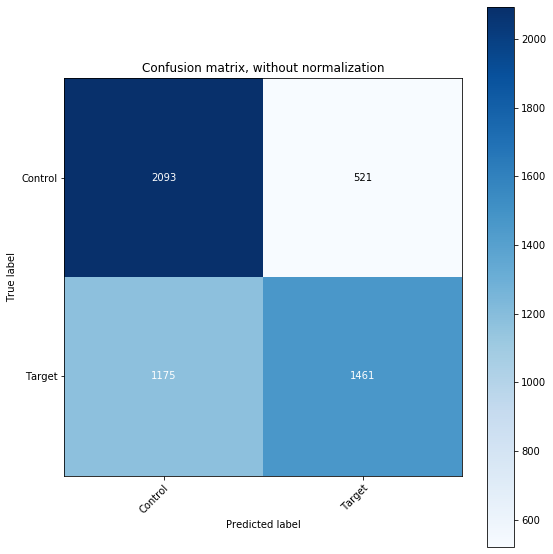

In [37]:
nn = build_dnn(num_features=train_data.shape[1])
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

cm = pipeline.train_model(batch_size=100,epochs=1, cross_validation=True, parallel=False, verbose=0)

In [13]:
_, correct_pred_idxs = pipeline.train_clusterer(plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:751

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (17, 17)
Halkidi-Filtered Noise    (12, 12)
dtype: object


In [22]:
def plot_clusters(pipeline):
    
    training_lrp = pipeline.training_lrp
    
    # Internally populates self.val_set_lrp
    samples, cluster_labels = pipeline.get_validation_clusters()
    
    val_lrp = pipeline.val_set_lrp
    # pipeline.reducer_pipeline[0].n_neighbors
    embedding_pipeline = Pipeline([
        ("reducer", umap.UMAP(random_state=42,
                        n_components = 3,
                        n_neighbors=25,
                        min_dist=0)),
       ("scaler", MinMaxScaler())
    ])
    embedding_pipeline.fit(training_lrp)

    embedding = embedding_pipeline.transform(training_lrp)

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=5,
            color=pipeline.clusterer.labels_,
            colorscale="Rainbow",
            opacity=0.8
        ),
        text=pipeline.clusterer.labels_
    )

    val_3d_embedding = embedding_pipeline.transform(val_lrp)

    val_emb3d = go.Scatter3d(
        x=val_3d_embedding[:,0],
        y=val_3d_embedding[:,1],
        z=val_3d_embedding[:,2],
        name="Validation",
        mode="markers",
        marker=dict(
            size=5,
            color=cluster_labels,
            colorscale='Viridis',
            opacity=0.8
    #         showscale=True
        ),
        text = cluster_labels
    )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )


    data=[emb3d, val_emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

In [38]:
# plot_clusters(pipeline)